<a href="https://colab.research.google.com/github/angarney/Deep_Learning_Project/blob/main/cnn_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Model Building for Handwritten Word Recognition

In [3]:
#Import necessary packages

# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline
# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']

#General packages
import pickle
from pathlib import Path
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, ImageColorGenerator
import numpy as np
from ann_visualizer.visualize import ann_viz

#Modeling packages
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Model
from tensorflow.keras.applications import mobilenet_v2
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, InputLayer
from keras.callbacks import EarlyStopping

Populating the interactive namespace from numpy and matplotlib


In [4]:
#Mount personal Google Drive - only needed once per session
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Bring in pickled objects
word_df = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/word_df','rb'))

## Add File Paths to Dataframe

In [6]:
#Mini function to update file mame
def update_id(input_string):
    additional_file_path = '/content/drive/MyDrive/Colab Notebooks/words_unzipped/words/'
    with_filepath_string = additional_file_path + input_string + '.png'
    return with_filepath_string

#Update word_id column with file path
word_df['word_id'] = word_df['word_id'].apply(update_id)

In [7]:
#Pickle objects for easier future import
pickle.dump(word_df, open('word_df','wb')) #Dataframe to use for image preprocessing

## Exploratory Data Analysis

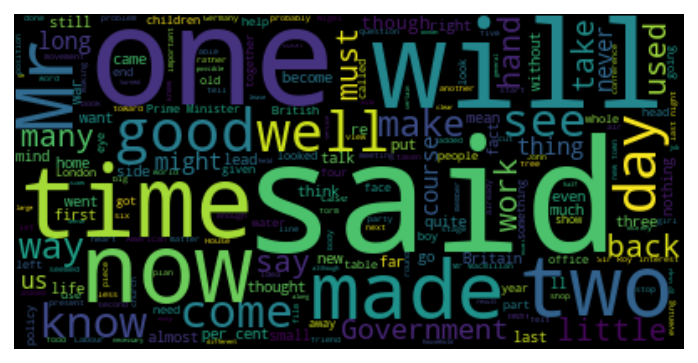

In [69]:
#Add wordcloud here for whole corpus
full_data_wordcloud = ' '.join(word_df['word_text']) #Create corpus

# Display the generated image
wordcloud = WordCloud().generate(full_data_wordcloud)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Create Samples of Datasets

In [8]:
#Create dataset with top ten classes
medium_word_df = word_df.sample(frac=.5, random_state=42, replace=False)
medium_word_df['word_counts'] = medium_word_df.groupby(['word_text'])['word_id'].transform('count')
medium_words_by_count = pd.DataFrame(medium_word_df.groupby(['word_text'])['word_id'].count())
top_ten_words = medium_word_df[medium_word_df['word_counts'] > 550].copy()

In [8]:
#Create sampled dataset for initial testing
tiny_word_df = word_df.sample(frac=.01, random_state=42, replace=False)
tiny_word_df['word_counts'] = tiny_word_df.groupby(['word_text'])['word_id'].transform('count')
tiny_words_by_count = pd.DataFrame(tiny_word_df.groupby(['word_text'])['word_id'].count())
top_seven_tiny_words = tiny_word_df[tiny_word_df['word_counts'] > 20].copy()

## Image Preprocessing

**7 Classes**

In [32]:
#Bring in data dataframe
final_word_df = top_seven_tiny_words

#Create training and hold-out sets
X_train, X_holdout, y_train, y_holdout = train_test_split(final_word_df['word_id'], final_word_df['word_text'], test_size=0.33, random_state=42)
training_set = pd.DataFrame({'word_id': X_train.to_list(), 'word_text': y_train.to_list()})
holdout_set = pd.DataFrame({'word_id': X_holdout.to_list(), 'word_text': y_holdout.to_list()})

#Bring in images
datagen=ImageDataGenerator(rescale=3./255., validation_split=.33)

seven_images_train = datagen.flow_from_dataframe(
    training_set,
    x_col='word_id',
    y_col='word_text',
    target_size=(256,256),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    subset="training"
)

seven_images_test = datagen.flow_from_dataframe(
    training_set,
    x_col='word_id',
    y_col='word_text',
    target_size=(256,256),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    subset="validation"
)

Found 71 validated image filenames belonging to 7 classes.
Found 34 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 91 invalid image filename(s) in x_col="word_id". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 91 invalid image filename(s) in x_col="word_id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


**10 Classes**

In [9]:
#Bring in data dataframe
final_word_df = top_ten_words

#Create training and hold-out sets
X_train, X_holdout, y_train, y_holdout = train_test_split(final_word_df['word_id'], final_word_df['word_text'], test_size=0.33, random_state=42)
training_set = pd.DataFrame({'word_id': X_train.to_list(), 'word_text': y_train.to_list()})
holdout_set = pd.DataFrame({'word_id': X_holdout.to_list(), 'word_text': y_holdout.to_list()})

#Bring in images
datagen=ImageDataGenerator(rescale=3./255., validation_split=.33)

ten_images_train = datagen.flow_from_dataframe(
    training_set,
    x_col='word_id',
    y_col='word_text',
    target_size=(256,256),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    subset="training"
)

ten_images_test = datagen.flow_from_dataframe(
    training_set,
    x_col='word_id',
    y_col='word_text',
    target_size=(256,256),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    subset="validation"
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 5131 invalid image filename(s) in x_col="word_id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3629 validated image filenames belonging to 10 classes.
Found 1787 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 5130 invalid image filename(s) in x_col="word_id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


## Create Model Baseline

In [24]:
#Model 1: Baseline - 7 classes and 1% sampling of data

#Build base model
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(256,256,3)) 

#Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False  

NN_transfer = Sequential(
                        [InputLayer(input_shape=(256,256,3)),
                         base_model,
                         Flatten(),
                         Dense(100, activation='relu'),
                         Dense(80, activation='relu'),
                         Dense(7, activation='softmax')]
                       )

NN_transfer.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

NN_transfer.fit_generator(generator=seven_images_train, epochs=5, steps_per_epoch=5, validation_data=seven_images_test, validation_steps=2, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
5/5 [==============================] - 13s 2s/step - loss: 7.9770 - accuracy: 0.2565 - val_loss: 9.3524 - val_accuracy: 0.4151
Epoch 2/5
5/5 [==============================] - 7s 2s/step - loss: 5.1078 - accuracy: 0.6356 - val_loss: 5.5936 - val_accuracy: 0.5849
Epoch 3/5
5/5 [==============================] - 8s 2s/step - loss: 0.8431 - accuracy: 0.8831 - val_loss: 4.9767 - val_accuracy: 0.6415
Epoch 4/5
5/5 [==============================] - 8s 2s/step - loss: 0.2076 - accuracy: 0.9700 - val_loss: 4.1780 - val_accuracy: 0.7736
Epoch 5/5
5/5 [==============================] - 8s 2s/step - loss: 0.1876 - accuracy: 0.9647 - val_loss: 4.8814 - val_accuracy: 0.7925


## Additional Model Building

In [40]:
#Model 2 - Increase dense layers using the same MobileNetV2 base model

#Build base model
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(256,256,3)) 

#Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False  

NN_transfer = Sequential(
                        [InputLayer(input_shape=(256,256,3)),
                         base_model,
                         Flatten(),
                         Dense(1000, activation='relu'),
                         Dense(100, activation='relu'),
                         Dense(7, activation='softmax')]
                       )

NN_transfer.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

NN_transfer.fit_generator(generator=seven_images_train, epochs=5, steps_per_epoch=5, validation_data=seven_images_test, validation_steps=2, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
5/5 [==============================] - 4s 326ms/step - loss: 15.3031 - accuracy: 0.3046 - val_loss: 12.6254 - val_accuracy: 0.5882
Epoch 2/5
5/5 [==============================] - 0s 96ms/step - loss: 2.1726 - accuracy: 0.8360 - val_loss: 20.8572 - val_accuracy: 0.5294
Epoch 3/5
5/5 [==============================] - 0s 99ms/step - loss: 1.0220 - accuracy: 0.9224 - val_loss: 11.2301 - val_accuracy: 0.6176
Epoch 4/5
5/5 [==============================] - 0s 89ms/step - loss: 0.0446 - accuracy: 0.9936 - val_loss: 10.5709 - val_accuracy: 0.7353
Epoch 5/5
5/5 [==============================] - 0s 111ms/step - loss: 0.1729 - accuracy: 0.9925 - val_loss: 12.8437 - val_accuracy: 0.7059


In [42]:
#Model 3 - Decrease alpha variable

#Build base model
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, alpha=.35, input_shape=(256,256,3)) 

#Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False  

NN_transfer = Sequential(
                        [InputLayer(input_shape=(256,256,3)),
                         base_model,
                         Flatten(),
                         Dense(1000, activation='relu'),
                         Dense(100, activation='relu'),
                         Dense(7, activation='softmax')]
                       )

NN_transfer.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

NN_transfer.fit_generator(generator=seven_images_train, epochs=5, steps_per_epoch=5, validation_data=seven_images_test, validation_steps=2, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
5/5 [==============================] - 4s 284ms/step - loss: 18.5966 - accuracy: 0.3666 - val_loss: 7.4429 - val_accuracy: 0.3235
Epoch 2/5
5/5 [==============================] - 0s 87ms/step - loss: 2.5481 - accuracy: 0.7083 - val_loss: 1.6614 - val_accuracy: 0.8824
Epoch 3/5
5/5 [==============================] - 0s 81ms/step - loss: 1.1877 - accuracy: 0.9363 - val_loss: 2.3173 - val_accuracy: 0.7941
Epoch 4/5
5/5 [==============================] - 0s 97ms/step - loss: 0.2767 - accuracy: 0.9689 - val_loss: 7.3358 - val_accuracy: 0.6471
Epoch 5/5
5/5 [==============================] - 0s 73ms/step - loss: 0.0266 - accuracy: 0.9835 - val_loss: 10.2258 - val_accuracy: 0.5294


In [43]:
#Model 4 - Add 3 additional classes and increase data sampling to 50% with baseline model

#Build base model
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(256,256,3)) 

#Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False  

NN_transfer = Sequential(
                        [InputLayer(input_shape=(256,256,3)),
                         base_model,
                         Flatten(),
                         Dense(100, activation='relu'),
                         Dense(80, activation='relu'),
                         Dense(10, activation='softmax')]
                       )

NN_transfer.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

NN_transfer.fit_generator(generator=ten_images_train, epochs=5, steps_per_epoch=168, validation_data=ten_images_test, validation_steps=83, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
168/168 [==============================] - 19s 102ms/step - loss: 2.5478 - accuracy: 0.6961 - val_loss: 0.7263 - val_accuracy: 0.8785
Epoch 2/5
168/168 [==============================] - 16s 96ms/step - loss: 0.3575 - accuracy: 0.9129 - val_loss: 0.6964 - val_accuracy: 0.8740
Epoch 3/5
168/168 [==============================] - 17s 99ms/step - loss: 0.0875 - accuracy: 0.9717 - val_loss: 0.6485 - val_accuracy: 0.8936
Epoch 4/5
168/168 [==============================] - 16s 96ms/step - loss: 0.1062 - accuracy: 0.9698 - val_loss: 0.7163 - val_accuracy: 0.9015
Epoch 5/5
168/168 [==============================] - 16s 96ms/step - loss: 0.0901 - accuracy: 0.9792 - val_loss: 0.9185 - val_accuracy: 0.8767


In [11]:
#Model 5 - Decrease alpha

#Build base model
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, alpha=0.35, input_shape=(256,256,3)) 

#Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False  

NN_transfer_final = Sequential(
                        [InputLayer(input_shape=(256,256,3)),
                         base_model,
                         Flatten(),
                         Dense(100, activation='relu'),
                         Dense(80, activation='relu'),
                         Dense(10, activation='softmax')]
                       )

NN_transfer_final.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

final_model_history = NN_transfer_final.fit_generator(generator=ten_images_train, epochs=5, steps_per_epoch=113, validation_data=ten_images_test, validation_steps=56, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
113/113 [==============================] - 1375s 12s/step - loss: 1.8223 - accuracy: 0.6934 - val_loss: 0.5855 - val_accuracy: 0.8663
Epoch 2/5
113/113 [==============================] - 10s 92ms/step - loss: 0.3226 - accuracy: 0.9099 - val_loss: 0.5534 - val_accuracy: 0.8858
Epoch 3/5
113/113 [==============================] - 11s 94ms/step - loss: 0.2661 - accuracy: 0.9241 - val_loss: 0.5190 - val_accuracy: 0.8926
Epoch 4/5
113/113 [==============================] - 11s 95ms/step - loss: 0.1250 - accuracy: 0.9663 - val_loss: 0.4887 - val_accuracy: 0.9093
Epoch 5/5
113/113 [==============================] - 10s 93ms/step - loss: 0.0931 - accuracy: 0.9697 - val_loss: 0.6074 - val_accuracy: 0.8970


In [45]:
#Model 6 - Increase units in dense layers

#Build base model
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, alpha=0.35, input_shape=(256,256,3)) 

#Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False  

NN_transfer = Sequential(
                        [InputLayer(input_shape=(256,256,3)),
                         base_model,
                         Flatten(),
                         Dense(1000, activation='relu'),
                         Dense(1000, activation='relu'),
                         Dense(10, activation='softmax')]
                       )

NN_transfer.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

NN_transfer.fit_generator(generator=ten_images_train, epochs=5, steps_per_epoch=168, validation_data=ten_images_test, validation_steps=83, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
168/168 [==============================] - 19s 100ms/step - loss: 4.0778 - accuracy: 0.7159 - val_loss: 0.4729 - val_accuracy: 0.9031
Epoch 2/5
168/168 [==============================] - 16s 97ms/step - loss: 0.2912 - accuracy: 0.9243 - val_loss: 0.7073 - val_accuracy: 0.8819
Epoch 3/5
168/168 [==============================] - 16s 98ms/step - loss: 0.2123 - accuracy: 0.9453 - val_loss: 0.6719 - val_accuracy: 0.9038
Epoch 4/5
168/168 [==============================] - 16s 98ms/step - loss: 0.1706 - accuracy: 0.9578 - val_loss: 0.8785 - val_accuracy: 0.8831
Epoch 5/5
168/168 [==============================] - 16s 97ms/step - loss: 0.1778 - accuracy: 0.9568 - val_loss: 0.8635 - val_accuracy: 0.8902


In [46]:
#Model 7 - Add an additional dense layer

#Build base model
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, alpha=0.35, input_shape=(256,256,3)) 

#Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False  

NN_transfer = Sequential(
                        [InputLayer(input_shape=(256,256,3)),
                         base_model,
                         Flatten(),
                         Dense(1000, activation='relu'),
                         Dense(1000, activation='relu'),
                         Dense(100, activation='relu'),
                         Dense(10, activation='softmax')]
                       )

NN_transfer.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

NN_transfer.fit_generator(generator=ten_images_train, epochs=5, steps_per_epoch=168, validation_data=ten_images_test, validation_steps=83, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
168/168 [==============================] - 19s 101ms/step - loss: 3.1434 - accuracy: 0.6409 - val_loss: 0.4569 - val_accuracy: 0.8921
Epoch 2/5
168/168 [==============================] - 16s 95ms/step - loss: 0.2653 - accuracy: 0.9280 - val_loss: 0.5290 - val_accuracy: 0.8940
Epoch 3/5
168/168 [==============================] - 16s 96ms/step - loss: 0.1367 - accuracy: 0.9605 - val_loss: 0.4625 - val_accuracy: 0.9083
Epoch 4/5
168/168 [==============================] - 16s 95ms/step - loss: 0.0987 - accuracy: 0.9714 - val_loss: 0.4328 - val_accuracy: 0.9189
Epoch 5/5
168/168 [==============================] - 16s 96ms/step - loss: 0.0490 - accuracy: 0.9842 - val_loss: 0.5629 - val_accuracy: 0.8970


In [47]:
#Model 8 - Go back to baseline dense layers due to overfitting and add early stopping

#Build base model
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, alpha=0.35, input_shape=(256,256,3)) 

#Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False  

NN_transfer = Sequential(
                        [InputLayer(input_shape=(256,256,3)),
                         base_model,
                         Flatten(),
                         Dense(100, activation='relu'),
                         Dense(80, activation='relu'),
                         Dense(10, activation='softmax')]
                       )

NN_transfer.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

early_stopping = EarlyStopping(monitor='val_loss',
                              verbose=1, mode='min')

NN_transfer.fit_generator(generator=ten_images_train, epochs=5, steps_per_epoch=168, validation_data=ten_images_test, validation_steps=83, verbose=1, callbacks=[early_stopping])


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
168/168 [==============================] - 19s 102ms/step - loss: 1.8838 - accuracy: 0.7222 - val_loss: 0.6510 - val_accuracy: 0.8604


# Final Testing with Select Model#5 on Holdout Set

In [14]:
#Bring in images
datagen=ImageDataGenerator(rescale=3./255.)

ten_images_holdout = datagen.flow_from_dataframe(
    holdout_set,
    x_col='word_id',
    y_col='word_text',
    target_size=(256,256),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

#Final model predictions
predictions = NN_transfer_final.predict_generator(ten_images_holdout, steps=2628)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2568 invalid image filename(s) in x_col="word_id". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Found 2628 validated image filenames belonging to 10 classes.


KeyboardInterrupt: ignored

In [15]:
#Accuracy of final model
results = NN_transfer_final.evaluate(ten_images_holdout, batch_size=32, steps=83)

83/83 [==============================] - 27s 324ms/step - loss: 0.5312 - accuracy: 0.8554


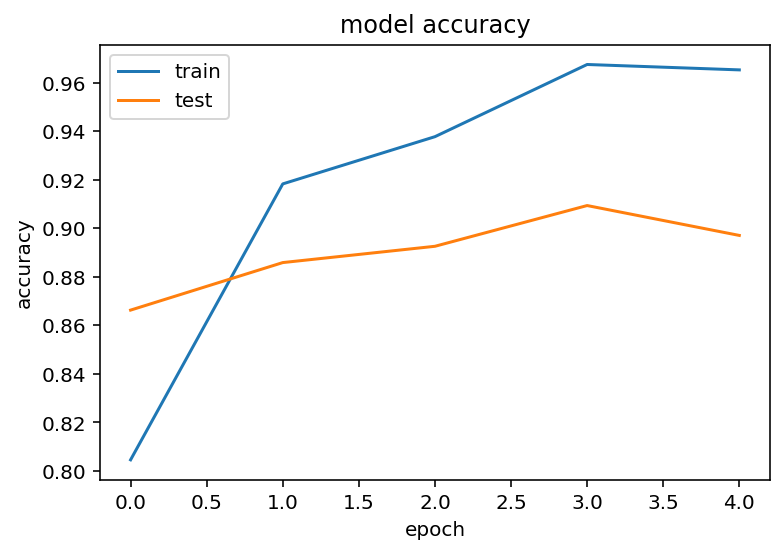

In [16]:
#Summarize history for accuracy
plt.plot(final_model_history.history['accuracy'])
plt.plot(final_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

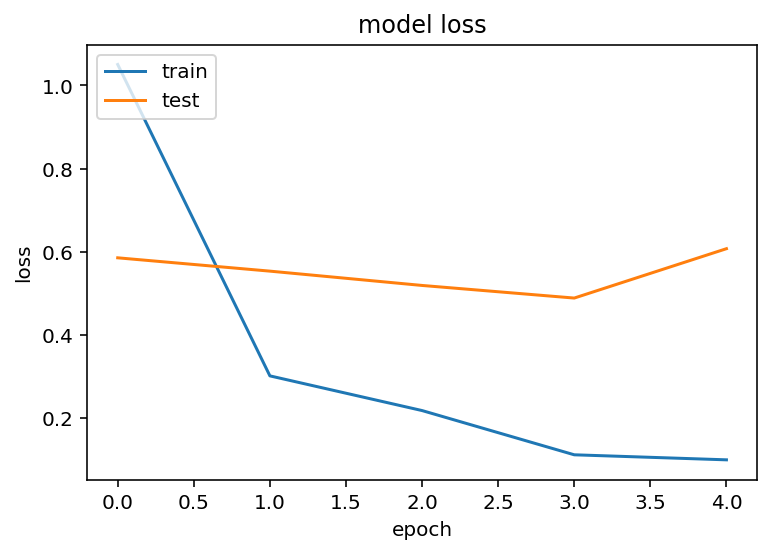

In [17]:
#Summarize history for loss
plt.plot(final_model_history.history['loss'])
plt.plot(final_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
#Create visualization of final model
ann_viz(NN_transfer_final, title="MobileNetV2 Transfer Learning Model")

ValueError: ignored